# Analyzing a Dynamical Model

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)
@[Chaoming Wang](https://github.com/chaoming0625)

In BrainPy, defined models can not only be used for simulation, but also to perform automatic dynamics analysis. 

BrainPy provides rich interfaces to support analysis, incluing

- Phase plane analysis, bifurcation analysis, and fast-slow bifurcation analysis for [low-dimensional systems](../tutorial_analysis/lowdim_analysis.ipynb);
- linearization analysis and fixed/slow point finding for [high-dimensional systems](../tutorial_analysis/highdim_analysis.ipynb). 

Here we will introduce three brief examples of 1-D bifurcation analysis and 2-D phase plane analysis. For more detailsand more examples, please refer to the tutorials of [dynamics analysis](../tutorial_analysis/index.rst).

In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

bp.math.enable_x64()  # Dynamics analysis in BrainPy requires 64-bit computation

## Example 1: bifurcation analysis of a 1D model

Here, we demonstrate how to perform a bifurcation analysis through a one-dimensional neuron model.

Let's try to analyze how the external input influences the dynamics of the Exponential Integrate-and-Fire (ExpIF) model. The ExpIF model is a one-variable neuron model whose dynamics is defined by:

$$
\tau {\dot {V}}= - (V - V_\mathrm{rest}) + \Delta_T \exp(\frac{V - V_T}{\Delta_T}) + RI \\
\mathrm{if}\, \, V > \theta, \quad  V \gets  V_\mathrm{reset}
$$

We can analyze the change of ${\dot {V}}$ with respect to $V$. First, let's generate an ExpIF model using pre-defined modules in ``brainpy.dyn``:

In [2]:
expif = bp.dyn.ExpIF(1, delta_T=1.)

The default value of other parameters can be accessed directly by their names:

In [3]:
expif.V_rest, expif.V_T, expif.R, expif.tau

(-65.0, -59.9, 1.0, 10.0)

After defining the model, we can use it for bifurcation analysis.

I am making bifurcation analysis ...


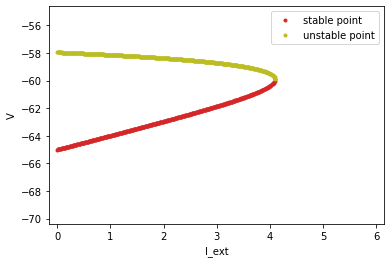

In [4]:
bif = bp.analysis.Bifurcation1D(
    model=expif,
    target_vars={'V': [-70., -55.]},
    target_pars={'I_ext': [0., 6.]},
    resolutions=0.01
)
bif.plot_bifurcation(show=True)

In the ``Bifurcation1D`` analyzer, ``model`` refers to the modelto be analyzed (essentially the analyzer will access the derivative function in the model), ``target_vars`` denotes the target variables, ``target_pars`` denotes the changing parameters, and ``resolution`` determines  the resolutioin of the analysis.

In the image above, there are two lines that "merge" together to form a bifurcation. The dots making up the lines refer to the fixed points of $\mathrm{d}V/\mathrm{d}t$. On the left of the bifurcation point (where two lines merge together), there are two fixed points where $\mathrm{d}V/\mathrm{d}t = 0$ given each external input $I_\mathrm{ext}$. One of them is a stable point, and the other is an unstable one. When $I_\mathrm{ext}$ increases, the two fixed points move closer to each other, overlap, and finally disappear.

Bifurcation analysis provides insights for the dynamics of the model, for it indicates the number and the change of stable states with respect to different parameters.

## Example 2: phase plane analysis of a 2D model

Besides bifurcationi analysis, another important tool is phase plane analysis, which displays the trajectory of the variable point in the vector field. Let's take the [FitzHugh–Nagumo (FHN) neuron model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.FHN.html) model as an example. The dynamics of the FHN model is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

Users can easily define a FHN model which is also provided by BrainPy:

In [5]:
fhn = bp.dyn.FHN(1)

Because there are two variables, $v$ and $w$, in the FHN model, we shall use 2-D phase plane analysis to visualize how these two variables change over time.

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating the vector field ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.2738719079879798, w=0.5329731346879486 is a unstable node.
I am plotting the trajectory ...


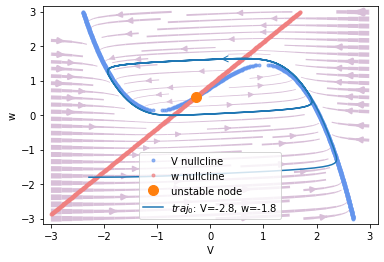

In [6]:
analyzer = bp.analysis.PhasePlane2D(
  model=fhn,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'I_ext': 0.8}, 
  resolutions=0.01,
)
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)
analyzer.show_figure()

In the ``PhasePlane2D`` analyzer, the parameters ``model``, ``target_vars``, and ``resolution`` is the same as those in ``Bifurcation1D``. ``pars_update`` specifies  the parameters to be updated during analysis. After defining the analyzer, users can visualize the nullcline, vector field, fixed points and the trajectory in the image. The phase plane gives users intuitive interpretation of the changes of $v$ and $w$ guided by the vector field (violet arrows).

## Further reading

- For more details about how to perform bifurcation analysis and phase plane analysis, please see the tutorial of [Low-dimensional Analyzers](../tutorial_analysis/lowdim_analysis.ipynb).
- A good example of phase plane analysis and bifurcation analysis is the decision-making model, please see the tutorial in [Analysis of a Decision-making Model](../tutorial_analysis/decision_making_model.ipynb)
- If you want to how to analyze the slow points (or fixed points) of your high-dimensional dynamical models, please see the tutorial of [High-dimensional Analyzers](../tutorial_analysis/highdim_analysis.ipynb)